In [43]:
# install machine gnostics

# recommended to run in a new virtual environment

# !pip install machine-gnostics

# Uncertainty Analysis

Example: Pressure measured for Pulsating Heat Pipe experiment. Here data itself is less and experiment is time consuming and expensive. Thus mean too many repeatation is a problem. Let's do a uncertainty analysis with help of Machine Gnostics!

In [44]:
# pressure data from PHP experiment
import numpy as np
data = np.array([0.75, 0.75, 0.71, 0.69, 0.79])

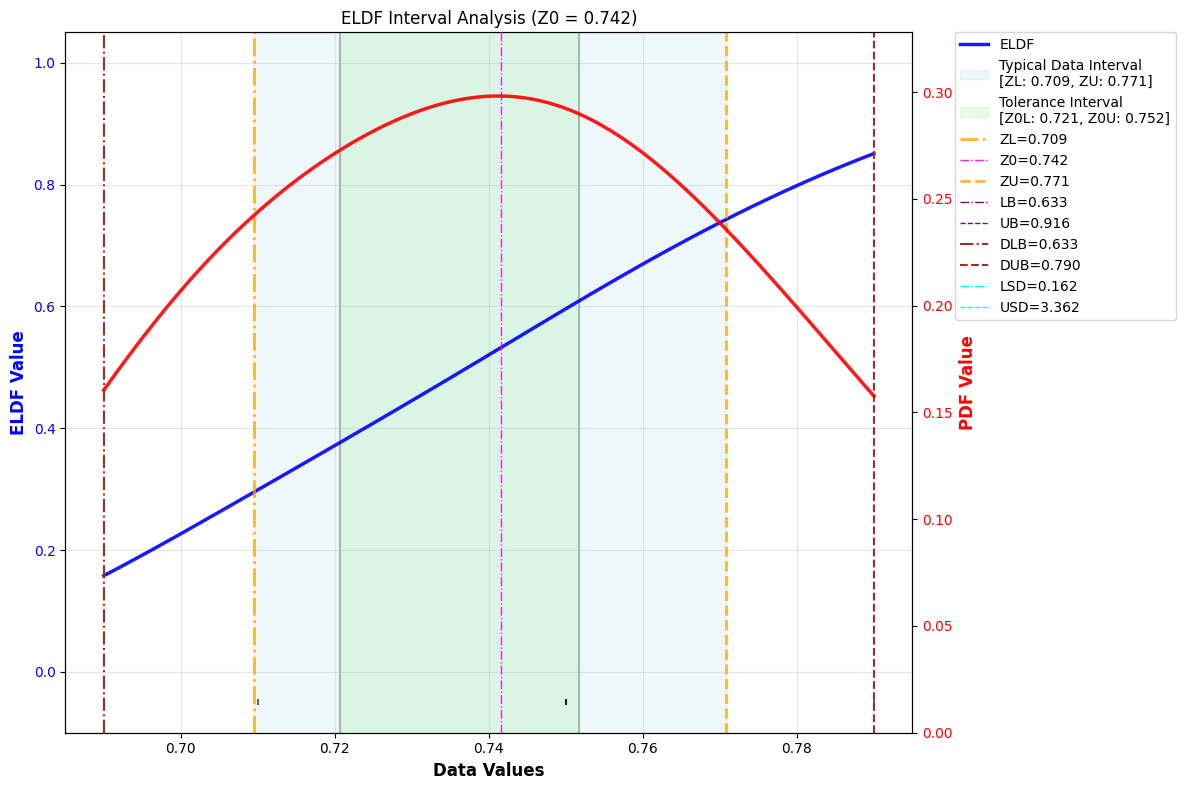

In [45]:
from machinegnostics.magcal import IntervalAnalysis

# create interval analysis object
ia = IntervalAnalysis()

# fit the data
intervals = ia.fit(data, plot=True)


In [46]:
# print intervals
# data certification
ia.results()

{'LB': 0.6329433840298194,
 'LSB': 0.69,
 'DLB': 0.69,
 'LCB': 0.69,
 'LSD': 0.1623704932355822,
 'ZL': 0.7094992999015113,
 'Z0L': 0.7207268489086702,
 'Z0': 0.7415151515151515,
 'Z0U': 0.7517433071978561,
 'ZU': 0.7707678281899265,
 'USD': 3.3620494128402387,
 'UCB': 0.788989898989899,
 'DUB': 0.79,
 'USB': 0.7921038685036703,
 'UB': 0.9158009996962903}

In [47]:
# Get interval results
results = ia.results()

# Extract values
Z0 = results['Z0']      # Mean value (center)
Z0L = results['Z0L']    # Tolerance interval lower
Z0U = results['Z0U']    # Tolerance interval upper
ZL = results['ZL']      # Typical data interval lower
ZU = results['ZU']      # Typical data interval upper

# Tolerance intervals
tolerance_interval = Z0U - Z0L
typical_data_interval = ZU - ZL

print(f"Mean (Z0): {Z0}")
print(f"Tolerance Interval: [{Z0L}, {Z0U}] with width {tolerance_interval}")
print(f"Typical Data Interval: [{ZL}, {ZU}] with width {typical_data_interval}")


Mean (Z0): 0.7415151515151515
Tolerance Interval: [0.7207268489086702, 0.7517433071978561] with width 0.031016458289185866
Typical Data Interval: [0.7094992999015113, 0.7707678281899265] with width 0.061268528288415225


/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_67503/473976734.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(x_pos, Z0,


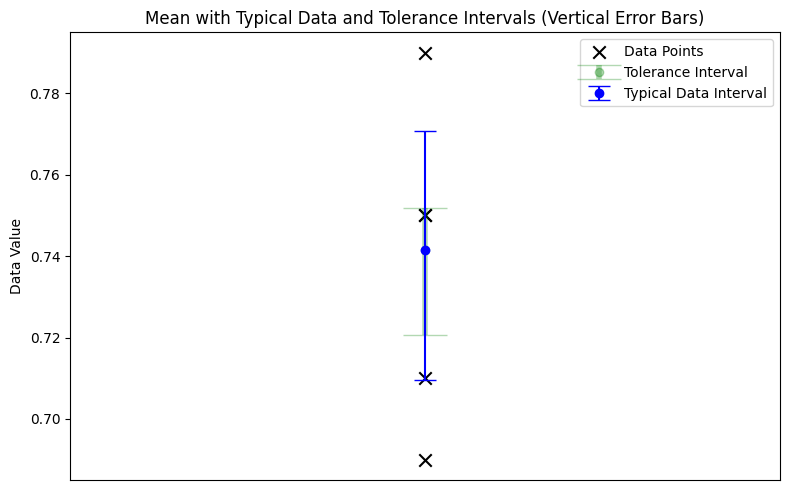

In [51]:
import matplotlib.pyplot as plt

# Calculate error bar lengths (for y-axis)
typical_lower = Z0 - ZL
typical_upper = ZU - Z0
tolerance_lower = Z0 - Z0L
tolerance_upper = Z0U - Z0

x_pos = 1  # Center position for error bars and data

plt.figure(figsize=(8, 5))

# Plot data points as cross marks, overlapping the error bars
plt.scatter([x_pos]*len(data), data, color='black', marker='x', s=80, label='Data Points')

# Plot mean value with tolerance interval as vertical error bar (thicker, behind)
plt.errorbar(x_pos, Z0, 
             yerr=[[tolerance_lower], [tolerance_upper]], 
             fmt='o', capsize=16, elinewidth=4, color='green', alpha=0.3, label='Tolerance Interval', zorder=1)

# Plot mean value with typical data interval as vertical error bar (in front)
plt.errorbar(x_pos, Z0, 
             yerr=[[typical_lower], [typical_upper]], 
             fmt='ro', capsize=8, label='Typical Data Interval', color='b', zorder=2)

plt.xticks([])
plt.ylabel('Data Value')
plt.legend()
plt.title('Mean with Typical Data and Tolerance Intervals (Vertical Error Bars)')
plt.tight_layout()
plt.show()